In [10]:
import glob
import numpy as np
import cv2
from cv2 import aruco
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pprint as pp

In [11]:
import math
def getJointVec(arr,joint_num):
    return np.array(arr[joint_num*4:joint_num*4+3])
def normalization(vec):
    return vec/np.linalg.norm(vec)
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))
def getAngle(v1, v2):
    return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

# Get Camera Parameters

In [12]:
parameter_dir=r"I:\20200720_FloorDetection\camera_parameter"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["0000","18284511","18284512"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]


for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(3):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]

In [13]:
camera_index = 0
length_of_axis = 0.09
markerLength = 0.09
mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]

In [15]:
pp.pprint(mtx)

array([[1.55407639e+03, 0.00000000e+00, 6.24039974e+02],
       [0.00000000e+00, 1.56162928e+03, 4.89631661e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])


<Figure size 432x288 with 0 Axes>

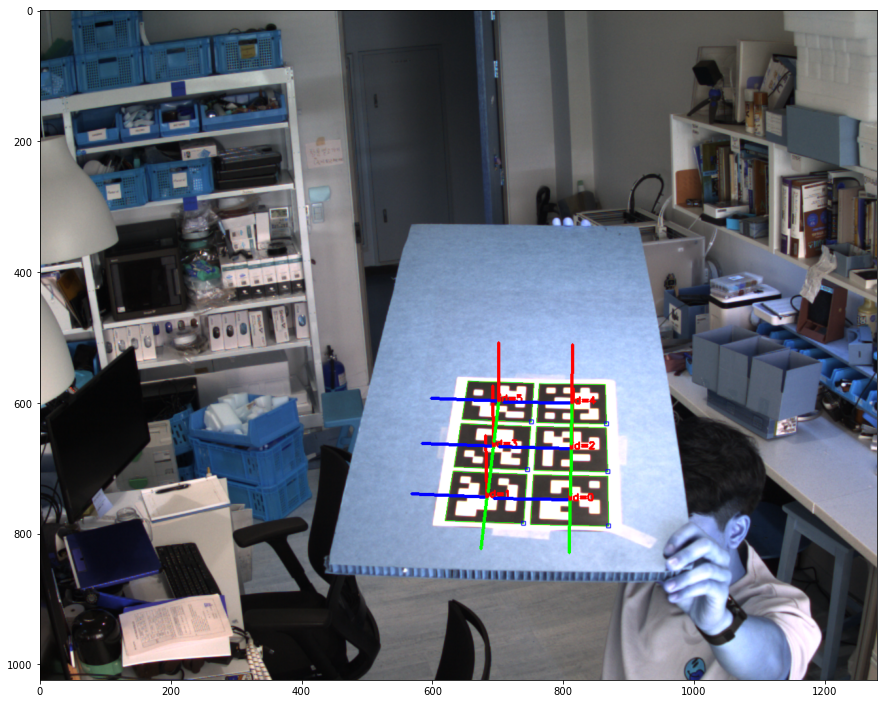

In [33]:
# image_data = r"C:\Users\ZAIO\Desktop\000000000000_rendered.png"
# image_data = r"I:\20200720_FloorDetection\000000000003_rendered.png"
# image_data = r"I:\20200720_FloorDetection\000000000019_rendered.png"
image_data = r"I:\20200721_Test_ArucoBoard\000000000020_rendered.png"


frame  = cv2.imread(image_data)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)


# for key, value in marker_dict.items():
#     imaxis = aruco.drawAxis(imaxis, mtx, dist,value["rvec"], value["tvec"], length_of_axis)
    
for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    
plt.figure()
plt.figure(figsize=(15,15))
plt.imshow(imaxis)
plt.show()

In [34]:
import pprint as pp
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    print(tvecs[idx][0])
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    marker_dict[marker_index] = _vecs

pp.pprint(marker_dict)
print(ids)

[0.14344284 0.19804608 1.18008014]
[0.0455321  0.19460579 1.18592667]
[0.15376287 0.14667193 1.26122496]
[0.05632943 0.14406969 1.2690105 ]
[0.16306167 0.09512886 1.33249481]
[0.06701056 0.09271996 1.3463594 ]
{0: {'rvec': array([ 0.10396169, -2.65213358,  1.49243275]),
     'tvec': array([0.14344284, 0.19804608, 1.18008014])},
 1: {'rvec': array([-0.11519128,  2.80224235, -1.59233857]),
     'tvec': array([0.0455321 , 0.19460579, 1.18592667])},
 2: {'rvec': array([ 0.10339262, -2.65466827,  1.50397933]),
     'tvec': array([0.15376287, 0.14667193, 1.26122496])},
 3: {'rvec': array([-0.12282281,  2.79357075, -1.59563902]),
     'tvec': array([0.05632943, 0.14406969, 1.2690105 ])},
 4: {'rvec': array([ 0.10737366, -2.63969145,  1.50555981]),
     'tvec': array([0.16306167, 0.09512886, 1.33249481])},
 5: {'rvec': array([ 0.11765635, -2.65713089,  1.52297194]),
     'tvec': array([0.06701056, 0.09271996, 1.3463594 ])}}
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [35]:
vec_0_to_1 = marker_dict[1]["tvec"] - marker_dict[0]["tvec"]
vec_0_to_2 = marker_dict[2]["tvec"] - marker_dict[0]["tvec"]

up_vector_marker  = np.cross(vec_0_to_1,vec_0_to_2) 
up_vector_marker = up_vector_marker/np.linalg.norm(up_vector_marker)
print("Up Vector from the Marker")
up_vector_marker
getAngle(vec_0_to_1,vec_0_to_2)

Up Vector from the Marker


92.17193981265991

In [36]:
def getVectorFromDic(idx0,idx1):
    return marker_dict[idx0]["tvec"] - marker_dict[idx1]["tvec"]

# idx0: origin
def getAngleFromDic(idx1,idx0,idx2):
    return getAngle(getVectorFromDic(idx2,idx0),getVectorFromDic(idx1,idx0))

def getDistanceFrom(idx0,idx1):
     return np.linalg.norm(getVectorFromDic(idx0,idx1))

In [37]:
print("012: "+ str(getAngleFromDic(1,0,2)))
print("210: "+ str(getAngleFromDic(2,1,0)))
print("210: "+ str(getAngleFromDic(0,2,1)))


print("104: "+ str(getAngleFromDic(1,0,4)))
print("204: "+ str(getAngleFromDic(2,0,4)))

012: 92.17193981265991
210: 43.47439168177307
210: 44.353668505567015
104: 92.13338805461163
204: 1.6813713870123184


In [38]:
print(getDistanceFrom(0,2))
print(getDistanceFrom(2,4))
print(getDistanceFrom(1,3))
print(getDistanceFrom(3,5))

print(getDistanceFrom(0,1))
print(getDistanceFrom(2,3))
print(getDistanceFrom(4,5))

0.09659341627358344
0.0884451650764356
0.09784376361364533
0.09345445271193119
0.09814544988114186
0.09777863495609422
0.0970764958417641


In [39]:
data = []
for key,value in marker_dict.items():
    data.append(value["tvec"])
data = np.array(data).T

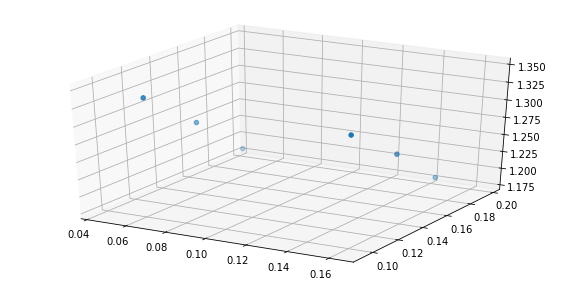

In [40]:
# plotting random walk by normal dist. 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(data[0],data[1], data[2], cmap='Greens');

In [39]:
ax.scatter3D(data[0],data[1], data[2], cmap='Greens');